# Cursive Handwriting OCR

## Biblioteke

In [96]:
import numpy as np
import cv2 # OpenCV
import matplotlib
import matplotlib.pyplot as plt
import collections
import math
import os
import random
import shutil
import io        # za open()
import re
import unicodedata
import pandas as pd

from scipy import ndimage
from scipy.ndimage import gaussian_filter, rotate, affine_transform
from scipy.ndimage import binary_dilation, binary_erosion

from PIL import Image, ImageDraw, ImageFont
# iscrtavanje slika u notebook-u
%matplotlib inline
# prikaz vecih slika
# keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image_dataset_from_directory

## Utility funkcije

Ovde se nalaze jednostavne funkcije za rad nad slikama kao i funkcije za rotiranje i promenu nagnutosti slike.

In [2]:
# Ćelija u kojoj se nalaze Utility funkcije

gpsv = np.random.default_rng(seed=42)

def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def display_image(image, color=False):
    if color:
        if len(image.shape) == 3 and image.shape[2] == 3:
            # Slika ima 3 kanala => verovatno BGR, konvertuj u RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.imshow(image_rgb)
        else:
            # Slika je grayscale (1 kanal), nema konverzije
            print("Upozorenje: Pokušaj prikaza grayscale slike kao RGB. Prikazujem kao grayscale.")
            plt.imshow(image, cmap='gray')
    else:
        # Uvek grayscale prikaz
        plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

def image_gray(image):
    # Ako slika već ima 1 kanal (grayscale), ne radi konverziju
    if len(image.shape) == 2:
        return image
    else:
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def image_bin(image_gs):                                                    # gs -> gray scale
    image_bin = cv2.adaptiveThreshold(image_gs, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 10)
    return image_bin

def invert(image):
    return 255-image

def invert_bin(image):
    return cv2.bitwise_not(image)

def dilate(image):                                                          # prosiruje bele delove slike
    kernel = np.ones((3, 3))                                                # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)

def erode(image):                                                           # smannjuje bele delove slike
    kernel = np.ones((3, 3))                                                # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

def opening(image):                                                            #otvaranje = erozija + dilacija
    return erode(dilate(image))                                             #uklanjanje šuma erozijom i vraćanje originalnog oblika dilacijom

def closing(image):                                                           #zatvaranje = dilacija + erozija,
    return dilate(erode(image))                                             #zatvaranje sitnih otvora među belim pikselima

def resize_region(region):
    # If region has a channel dimension, remove it for resizing
    if len(region.shape) == 3 and region.shape[2] == 1:
        region_2d = region.squeeze(axis=2)
    else:
        region_2d = region
    
    # Resize the 2D image
    resized = cv2.resize(region_2d, (64, 64), interpolation=cv2.INTER_AREA)
    
    return resized

def matrix_to_vector(image):                                                #pretvara sliku u vektoru
    return image.flatten()

def scale_to_range(image):                                                  #skalira boje sa opsega [0, 255] na [0, 1]   
    # Convert to float32 first
    image = image.astype(np.float32)
    
    # Normalize based on the actual range, not assuming [0, 255]
    image_min = np.min(image)
    image_max = np.max(image)
    
    if image_max > 1.0:  # Assume it's in [0, 255] range
        image = image / 255.0
    # If already in [0, 1] range, don't change it
    
    return image

In [3]:
# Ćelija u kojoj se nalazi algoritam za rotiranje slike

def rotate_image_to_normal(image, image_grayscale):
    image_edges = cv2.Canny(image_grayscale, 100, 100, apertureSize=3)
    lines = cv2.HoughLinesP(image_edges, 1, math.pi / 180.0, 100, maxLineGap=5)

    angles = []

    if lines is not None:
        for [[x1, y1, x2, y2]] in lines:
            angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
            angles.append(angle)
    
        median_angle = np.median(angles)
        image_rotated = ndimage.rotate(image, median_angle)
    else:
        print("Upozorenje: Nisu pronađene linije za rotaciju. Slika neće biti rotirana.")
        image_rotated = image                                                     # Vraćamo originalnu sliku bez rotacije
    return image_rotated

In [4]:
# Ćelija u kojoj se nalazi kod koji ispravlja nagnutu sliku

def order_points(pts):                                                                                 # pomoćna funkcija, biće potrebna za correct_skewed_image
    rect = np.zeros((4, 2), dtype="float32")                                                           

    s = pts.sum(axis=1)                                                                               
    rect[0] = pts[np.argmin(s)]                                                                         # top-left (najmanji zbir x + y)
    rect[2] = pts[np.argmax(s)]                                                                         # bottom-right (najveći zbir x + y)

    diff = np.diff(pts, axis=1)                                                                        
    rect[1] = pts[np.argmin(diff)]                                                                      # top-right (najmanja razlika x - y)
    rect[3] = pts[np.argmax(diff)]                                                                      # bottom-left (najveća razlika x - y)

    return rect


def correct_skewed_image(image):
    gray = image_gray(image)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    image_area = image.shape[0] * image.shape[1]
    found = False

    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
        area = cv2.contourArea(contour)

        print(f"Dužina konture: {len(approx)}, Površina: {area:.2f}, Udeo u slici: {area / image_area:.2%}")

        if len(approx) == 4 and area > 0.5 * image_area:
            screen_cnt = approx
            found = True

            # Prikaz konture za proveru
            debug_img = image.copy()
            cv2.drawContours(debug_img, [screen_cnt], -1, (0, 255, 0), 2)
            print("Pronađena validna kontura sa 4 temena.")
            display_image(debug_img, color=True)
            break

    if not found:
        print("Nije pronađena validna kontura za ispravljanje.")
        return image  # Vraća original ako nema dovoljno dobre konture

    rect = order_points(screen_cnt.reshape(4, 2))
    (tl, tr, br, bl) = rect

    width_a = np.linalg.norm(br - bl)
    width_b = np.linalg.norm(tr - tl)
    max_width = max(int(width_a), int(width_b))

    height_a = np.linalg.norm(tr - br)
    height_b = np.linalg.norm(tl - bl)
    max_height = max(int(height_a), int(height_b))

    dst = np.array([
        [0, 0],
        [max_width - 1, 0],
        [max_width - 1, max_height - 1],
        [0, max_height - 1]
    ], dtype="float32")

    print("Dimenzije transformacije:", max_width, "x", max_height)
    print("Tačke ulaza (rect):", rect)
    print("Tačke izlaza (dst):", dst)

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))

    return warped

## ROI Selection

Ovde se nalaze funkcije koje se koriste za odabir Regiona od interesa (ROI), nad trening i nad testnim podacima.

In [5]:
# Ćelija u kojoj se nalazi kod koji se koristi za spajanje ROI koji se nalaze na trening podacima

def select_roi_training(image_orig, image_bin):
    contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    regions_array = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        region = image_bin[y:y+h, x:x+w]
        if region is not None:
            regions_array.append([region, (x, y, w, h)])

    # Konture koje sadrze kukice
    connected_regions = [] 
    # Prolazimo kroz niz i proveravamo da li u ostatku niza postoji neki region iznad ili ispod trenutnog i ako 
    # postoji takav region, pravimo jedan veci region oko njih i dodajemo ga
    for region1, (x1, y1, w1, h1) in regions_array:
        for _region2, (x2, y2, w2, h2) in regions_array:
            # Provera da li je isti region
            if (x1, y1, w1, h1) == (x2, y2, w2, h2):
                continue
            mid_x2 = x2 + w2 // 2

            # Provera da li je region kvacica
            if (y1 >= y2 or y1 <= y2) and mid_x2 >= x1 and mid_x2 <= x1 + w1:
                x_min = min(x1, x2)
                y_min = min(y1, y2)
                x_max = max(x1 + w1, x2 + w2) # Desna ivica
                y_max = max(y1 + h1, y2 + h2) # Donja ivica

                # Novi kombinovani bounding box (x3, y3, w3, h3)
                x3 = x_min
                y3 = y_min
                w3 = x_max - x_min
                h3 = y_max - y_min
                region3 = image_bin[y3:y3+h3, x3:x3+w3]
                connected_regions.append([resize_region(region3), (x3, y3, w3, h3)])

    # Sad cemo proci kroz niz regions_array i videti da li se centar tih objekata nalazi unutar 
    # nekog veceg koji je u connected_regions
    # Filtiramo regione tako da na primer za slovo ž sad imamo 2 regiona u regions_array i 1 veci
    # region u connected_regions
    # Ona 2 regiona ne dodajemo u filtrirane regione dok cemo 1 veci region dodati kasnije
    # Ako se nalazi, preskacemo taj objekat, a ako ne onda ga dodajemo u nov niz
    filtered_regions = []
    for region1, (x1, y1, w1, h1) in regions_array:
        mid_x1 = x1 + w1 // 2
        mid_y1 = y1 + h1 // 2
        is_in = False
        for _region2, (x2, y2, w2, h2) in connected_regions:
            if mid_x1 >= x2 and mid_x1 <= x2 + w2 and mid_y1 >= y2 and mid_y1 <= y2 + h2:
                is_in = True
        if not is_in:
            filtered_regions.append([region1, (x1, y1, w1, h1)])
    
    # Dodajemo i one velike regione u kojem su slova sa kukicama
    for connected_region, (x1, y1, w1, h1) in connected_regions:
        is_in = False
        for region, (x2, y2, w2, h2) in filtered_regions:
            if (x1, y1, w1, h1) == (x2, y2, w2, h2):
                is_in = True
                break
        if not is_in:
            filtered_regions.append([connected_region, (x1, y1, w1, h1)])

    # Iscrtavamo sve te regione
    for _, (x, y, w, h) in filtered_regions:
        cv2.rectangle(image_orig, (x, y), (x + w, y + h), (255, 0, 0), 2)
        
    # Sortiramo niz u kojem su elementi [region, koordinate] po velicini regiona
    filtered_regions = sorted(filtered_regions, key=lambda x: x[1][2] * x[1][3], reverse=True)
    sorted_regions = [resize_region(region[0]) for region in filtered_regions]

    if len(sorted_regions) == 0:
        return image_orig, [image_bin]
    else:
        return image_orig, sorted_regions

In [6]:
# Ćelija u kojoj se nalazi kod koji se koristi za spajanje ROI koji se nalaze na testnim podacima

# ISTA CELIJA KAO ZA Z2V5 
# Ideja za resenje:
# Priprema za algoritam:
# 1. Neophodno je uraditi selekciju ROI tako da se upamte centri svih kontura u jednom nizu kao i pravougaonici oko kontura
# (2.) Eventualno se mogu upamtiti i visine svih karaktera zbog koraka 2 u algoritmu, to ipak nije uradjeno
# Obrada red po red po sledecim pravilima:
# 1. Uzeti minimalnu y-vrednost centra karaktera u samom nizu centara i izdvojiti ga u poseban niz i obrisati iz trenutnog
# 2. Proci kroz ostatak niza i proveriti da li postoje karakteri sa slicnom y-vrednost centra (y-centar + (visina-karaktera / 2 ili prosto 14 ili prosecna-visina-svih-karaktera / 2)) i dodati ih u poseban niz i obrisati iz trenutnog
# 3. Sortirati poseban niz po x-vrednosti centara i sracunati udaljenosti izmedju svaka 2 karaktera kako bismo mogli uraditi KMeans nad ovim redom
# 4. Prikazemo rezultat samo tog jednog reda sa razmacima i dodamo '\n' na kraj rezultata
# 5. Ponavljamo korake 1-4 sve dok ne dobijemo prazan red centara
# Imas claude i gpt odgovor na ovo :3

# Ideja za verziju 2
# Implementirati isto kao i sto je radjeno sa razmacima ali upotrebom DBSCAN algoritma

# Za detaljno objasnjenje posetiti sajt koji je preporucen za Non-Maximum Suppresion
# https://pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/

def non_max_suppression_slow(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# initialize the list of picked indexes
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list, add the index
		# value to the list of picked indexes, then initialize
		# the suppression list (i.e. indexes that will be deleted)
		# using the last index
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		suppress = [last]
				# loop over all indexes in the indexes list
		for pos in range(0, last):
			# grab the current index
			j = idxs[pos]
			# find the largest (x, y) coordinates for the start of
			# the bounding box and the smallest (x, y) coordinates
			# for the end of the bounding box
			xx1 = max(x1[i], x1[j])
			yy1 = max(y1[i], y1[j])
			xx2 = min(x2[i], x2[j])
			yy2 = min(y2[i], y2[j])
			# compute the width and height of the bounding box
			w = max(0, xx2 - xx1 + 1)
			h = max(0, yy2 - yy1 + 1)
			# compute the ratio of overlap between the computed
			# bounding box and the bounding box in the area list
			overlap = float(w * h) / area[j]
			# if there is sufficient overlap, suppress the
			# current bounding box
			if overlap > overlapThresh:
				suppress.append(pos)
		# delete all indexes from the index list that are in the
		# suppression list
		idxs = np.delete(idxs, suppress)
	# return only the bounding boxes that were picked
	return boxes[pick]

def select_roi_test(image_orig, image_bin):
	contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
	sorted_regions = [] # lista sortiranih regiona po X osi
	regions_array = []
	for contour in contours:
		x, y, w, h = cv2.boundingRect(contour) # koordinate i velicina granicnog pravougaonika
		# kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
		# oznaciti region pravougaonikom na originalnoj slici sa rectangle funkcijom
		region = image_bin[y:y+h+1, x:x+w+1]
		regions_array.append([resize_region(region), (x, y, w, h)])

	#
	#
	# ---------- DEO KOJI JE ISTI KAO ONAJ ZA KVACICE ----------
	#
	#
	# Konture koje sadrze kukice
	connected_regions = [] 
	# Prolazimo kroz niz i proveravamo da li u ostatku niza postoji neki region iznad ili ispod trenutnog i ako 
	# postoji takav region, pravimo jedan veci region oko njih i dodajemo ga
	for region1, (x1, y1, w1, h1) in regions_array:
		for _region2, (x2, y2, w2, h2) in regions_array:
			# Provera da li je isti region
			if (x1, y1, w1, h1) == (x2, y2, w2, h2):
				continue
			mid_x2 = x2 + w2 // 2

            # Provera da li je region kvacica
			if (y1 >= y2 or y1 <= y2) and mid_x2 >= x1 and mid_x2 <= x1 + w1:
				x_min = min(x1, x2)
				y_min = min(y1, y2)
				x_max = max(x1 + w1, x2 + w2) # Rightmost edge
				y_max = max(y1 + h1, y2 + h2) # Bottommost edge

				# New combined bounding box (x3, y3, w3, h3)
				x3 = x_min
				y3 = y_min
				w3 = x_max - x_min
				h3 = y_max - y_min
				region3 = image_bin[y3:y3+h3, x3:x3+w3]
				
				connected_regions.append([resize_region(region3), (x3, y3, w3, h3)])

	# Sad cemo proci kroz niz regions_array i videti da li se centar tih objekata nalazi unutar 
	# nekog veceg koji je u connected_regions
	# Filtiramo regione tako da na primer za slovo ž sad imamo 2 regiona u regions_array i 1 veci
	# region u connected_regions
	# Ona 2 regiona ne dodajemo u filtrirane regione dok cemo 1 veci region dodati kasnije
	# Ako se nalazi, preskacemo taj objekat, a ako ne onda ga dodajemo u nov niz
	filtered_regions = []
	for region1, (x1, y1, w1, h1) in regions_array:
		mid_x1 = x1 + w1 // 2
		mid_y1 = y1 + h1 // 2
		is_in = False
		for _region2, (x2, y2, w2, h2) in connected_regions:
			if mid_x1 >= x2 and mid_x1 <= x2 + w2 and mid_y1 >= y2 and mid_y1 <= y2 + h2:
				is_in = True
		if not is_in:
			filtered_regions.append([region1, (x1, y1, w1, h1)])
    
    # Dodajemo i one velike regione u kojem su slova sa kukicama
	for connected_region, (x1, y1, w1, h1) in connected_regions:
		is_in = False
		for region, (x2, y2, w2, h2) in filtered_regions:
			if (x1, y1, w1, h1) == (x2, y2, w2, h2):
				is_in = True
				break
		if not is_in:
			filtered_regions.append([connected_region, (x1, y1, w1, h1)])
	#
	#
	# ---------- KRAJ DELA KOJI JE ISTI KAO ONAJ ZA KVACICE ----------
	#
	#

	regions_array = filtered_regions
	# Pripremamo podatke za NMS funkciju jer ona uzima podatke u obliku [x1, y1, x2, y2] (gornje levo teme i donje desno teme pravougaonika)
	# Dok mi radimo ovde samo sa (y1, x1) <- dovoljno je znati samo gornje levo teme jer znamo da su svi auti dimenzija 100x40 (width x height)
	boundingBoxes = np.zeros((len(regions_array), 4))
	for i in range(len(regions_array)):
		x, y, w, h = regions_array[i][1]
		boundingBoxes[i] = [x, y, x + w, y + h]

	# Primenjujemo NMS
	boundingBoxes = non_max_suppression_slow(boundingBoxes, 0.3)
	# Vracamo podatke u oblik [x, y, w, h]
	boundingBoxes = [[x1, y1, x2 - x1, y2 - y1] for (x1, y1, x2, y2) in boundingBoxes]

	# Pravimo skup od tih podataka, u skupu se nalaze samo x vrednosti koordinata
	bounding_box_set = set(box[0] for box in boundingBoxes)
	# Filtriramo regions_array kako bismo samo zadrzali elemente koje nam je NMS vratio
	filtered_regions = [
        item for item in regions_array 
        if item[1][0] in bounding_box_set
    ]

	# Iscrtavamo pravougaonike oko svakog od filtriranih regiona
	for _, (x,y,w,h) in filtered_regions:
		cv2.rectangle(image_orig, (x, y), (x + w, y + h), (0, 255, 0), 2)

	# Sortiramo filtrirane regione
	filtered_regions = sorted(filtered_regions, key=lambda x: x[1][0])

	# Izdvajamo same regione
	sorted_regions = [region[0] for region in filtered_regions]

	# Izdvajamo centre regione u oblik (x_centar, y_centar)
	regions_centers = [] # lista centara samih karaktera
	regions_centers = [(region[1][0] + region[1][2] // 2, region[1][1] + region[1][3] // 2) for region in filtered_regions]
	
	# Izdvajamo [x, y, w, h] iz regiona
	sorted_rectangles = [region[1] for region in filtered_regions]
	return image_orig, sorted_regions, regions_centers, sorted_rectangles

## Funkcije za kreiranje, treniranje i ispis rezultata NM

In [36]:
# Neuronska mreža

def create_cnn(output_size):                                        #pravljenje neuronske mreze
    model = Sequential()

    # Dublja CNN za rukopis
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def prepare_for_cnn_one_region(region):

    resized_region = image_bin(resize_region(region))

    region_with_channel = np.reshape(resized_region, (64, 64, 1))  # Dodavanje dimenzije kanala
        
    return np.array(region_with_channel, dtype=np.float32)

def prepare_for_cnn(regions):
    ready_for_ann = []
    for region in regions:
        resized_region = resize_region(region)
        normalized_region = scale_to_range(resized_region)

        region_with_channel = np.reshape(resized_region, (64, 64, 1))  # Dodavanje dimenzije kanala
        ready_for_ann.append(region_with_channel)
        
    return np.array(ready_for_ann, dtype=np.float32)

def convert_output(alphabet):                                       #u sustini a je [1 0 0 ... ], b je [0, 1, 0..]
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))                            #napravimo niz nula
        output[index] = 1                                           #na redni broj slova u alfabetu ide 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

def train_cnn(cnn, train, validation, epochs):

    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=12,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,  # Reduce LR by half
            patience=5,  # Wait 5 epochs before reducing
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    print("\nTraining started...")
    history = cnn.fit(train, epochs=epochs, verbose=1, validation_data=validation, callbacks=callbacks)
    print("\nTraining completed...")
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    return cnn

def winner(output):                                                                    # odredjuje pobednicki neuron, onaj  neuron
    return max(enumerate(output), key=lambda x: x[1])[0]                               # cija je aktivaciona vrednost najveca

def display_result_with_spaces(outputs, alphabet, k_means):
    if k_means is None:
        print(outputs[0])
        return alphabet[winner(outputs[0])]    
                                                          
    w_space_group = max(enumerate(k_means.cluster_centers_), key=lambda x: x[1])[0]    # odredjuje rastojanje izmedju reci (max)
                                                                                       # enumerate daje parove
    result = alphabet[winner(outputs[0])]
                                                                                                                        
    for idx, output in enumerate(outputs[1:, :]):
        if k_means.labels_[idx] == w_space_group:
            result += ' '
        result += alphabet[winner(output)]
    return result

## Pomoćne funkcije za kreiranje dodatnih slova

Sledeće ćelije sadrže funkcije koje obrađuju jednu prosleđenu sliku ili kreiraju u potpunosti novu sliku i čuvaju je na specifiranoj lokaciji.

Ove funkcije se koriste za generisanje: 

- Slova latinice: Č, č, Ž, ž, Š, š, Ć, ć, Đ, đ;
- Slova ćirilice: Ђ, ђ, Љ, љ, Њ, њ, Ћ, ћ, Џ, џ, Д.

In [ ]:
# Funkcije za kreiranje jedne slike potrebnog slova latinice

# Kreiranje (i velikih i malih) slova Č, č, Ž, ž, Š, š 
def create_caron_letter(image_path, output_path):
    # Učitavanje slike i dobijanje dimenzija
    image = image_bin(image_gray(load_image(image_path))) 
    height, width = image.shape[:2]

    # Proširivanje slike za prostor na vrhu za caron
    extra_top_space = 16
    new_height = height + extra_top_space

    # Kreiranje nove bele slike
    new_image = 255 * np.ones((new_height, width), dtype=np.uint8)

    # Dodavanje originalne slike na dno nove slike
    new_image[extra_top_space:, :] = image

    # Priprema za crtanje ˇ - malo "v"
    caron_center_x = width // 2 + gpsv.integers(-4, 5)
    caron_bottom_y = extra_top_space - 4 + gpsv.integers(-2, 1)
    caron_width = width // 2 - 14 + gpsv.integers(-4, 5)
    caron_height = 8 + gpsv.integers(-2, 3)
    thickness = gpsv.integers(2, 5)

    # Definisanje tačaka za crtanje ˇ
    pt1 = (caron_center_x - caron_width, caron_bottom_y - caron_height)
    pt2 = (caron_center_x, caron_bottom_y)
    pt3 = (caron_center_x + caron_width, caron_bottom_y - caron_height)

    # Crtanje ˇ - malo "v"
    cv2.line(new_image, pt1, pt2, (0,), thickness)
    cv2.line(new_image, pt2, pt3, (0,), thickness)

    # Brisanje praznog prostora iznad slova
    slider_y = 0
    while slider_y < new_height:
        if np.any(new_image[slider_y, :] == 0):
            break
        slider_y += 1

    new_image = new_image[slider_y:, :]

    # Čuvanje rezultata
    _, img_bin = select_roi_training(new_image, new_image)
    if img_bin:
        first_region_image = img_bin[0]
        cv2.imwrite(output_path, image_bin(first_region_image))


# Kreiranje (i velikog i malog) slova Ć, ć
def create_acute_accent_letter(image_path, output_path):
    # Učitavanje slike i dobijanje dimenzija
    image = image_bin(image_gray(load_image(image_path))) 
    height, width = image.shape[:2]

    # Proširivanje slike za prostor na vrhu za caron
    extra_top_space = 16
    new_height = height + extra_top_space

    # Kreiranje nove bele slike
    new_image = 255 * np.ones((new_height, width), dtype=np.uint8)

    # Dodavanje originalne slike na dno nove slike
    new_image[extra_top_space:, :] = image

    # Priprema za crtanje ´
    caron_center_x = width // 2 + gpsv.integers(-4, 5)
    caron_bottom_y = extra_top_space - 4 + gpsv.integers(-2, 1)
    caron_width = width // 2 - 14 + gpsv.integers(-4, 5)
    caron_height = 8 + gpsv.integers(-2, 3)
    thickness = gpsv.integers(2, 5)

    # Definisanje tačaka za crtanje ´
    pt1 = (caron_center_x, caron_bottom_y)
    pt2 = (caron_center_x + caron_width, caron_bottom_y - caron_height)

    # Crtanje ´
    cv2.line(new_image, pt1, pt2, (0,), thickness)

    # Brisanje praznog prostora iznad slova
    slider_y = 0
    while slider_y < new_height:
        if np.any(new_image[slider_y, :] == 0):
            break
        slider_y += 1

    new_image = new_image[slider_y:, :]

    # Čuvanje rezultata
    _, img_bin = select_roi_training(new_image, new_image)
    if img_bin:
        first_region_image = img_bin[0]
        cv2.imwrite(output_path, image_bin(first_region_image))

In [ ]:
# Funkcije za kreiranje jedne slike potrebnog slova

def get_letter_info(letter):
    """
    Get information about a letter for display purposes.
    
    Args:
        letter (str): The letter to analyze
        
    Returns:
        dict: Dictionary with letter information
    """
    
    info = {
        'character': letter,
        'unicode_point': f"U+{ord(letter):04X}",
        'decimal': ord(letter)
    }
    
    try:
        info['unicode_name'] = unicodedata.name(letter)
    except ValueError:
        info['unicode_name'] = "Unknown"
    
    try:
        info['category'] = unicodedata.category(letter)
    except:
        info['category'] = "Unknown"
    
    return info

def add_handwriting_variations(img_array, variation_strength=0.3):
    """
    Add handwriting-like variations to the image.
    
    Args:
        img_array (numpy.ndarray): Input binary image (0=black letter, 1=white background)
        variation_strength (float): Strength of variations (0.0 to 1.0)
    
    Returns:
        numpy.ndarray: Modified image with handwriting variations
    """
    
    # Ensure we're working with the correct format (0=letter, 1=background)
    img_float = img_array.astype(np.float32)
    
    # Add slight blur to simulate ink bleeding (only if there's actually content)
    if np.any(img_array == 0):  # Only if there are black pixels
        blur_sigma = random.uniform(0.2, 0.6) * variation_strength
        img_float = gaussian_filter(img_float, sigma=blur_sigma)
    
    # Add random thickness variations
    if random.random() < 0.6 and np.any(img_array == 0):  # 60% chance if letter exists
        # Create random structuring element
        struct_size = random.choice([3, 3, 5])  # Favor smaller structures
        struct = np.ones((struct_size, struct_size))
        
        # Convert to binary for morphological operations (True=letter, False=background)
        binary_img = img_float < 0.5
        
        if random.random() < 0.4:
            # Make slightly thicker
            binary_img = binary_dilation(binary_img, structure=struct, iterations=1)
        else:
            # Make slightly thinner (but be careful not to erase everything)
            if np.sum(binary_img) > 50:  # Only if there's enough content
                binary_img = binary_erosion(binary_img, structure=struct, iterations=1)
        
        # Convert back to our format (0=letter, 1=background)
        img_float = (~binary_img).astype(np.float32)
    
    # Add very small random breaks (sparingly)
    if random.random() < 0.2 and np.any(img_array == 0):  # 20% chance if letter exists
        num_breaks = random.randint(1, 2)
        for _ in range(num_breaks):
            # Find existing letter pixels
            letter_pixels = np.where(img_array == 0)
            if len(letter_pixels[0]) > 0:
                idx = random.randint(0, len(letter_pixels[0]) - 1)
                y, x = letter_pixels[0][idx], letter_pixels[1][idx]
                # Add small white spot
                size = random.randint(1, 2)
                y_start, y_end = max(0, y-size//2), min(img_array.shape[0], y+size//2+1)
                x_start, x_end = max(0, x-size//2), min(img_array.shape[1], x+size//2+1)
                img_float[y_start:y_end, x_start:x_end] = 1.0
    
    # Convert back to binary, ensuring consistent format
    result = (img_float > 0.5).astype(np.uint8)
    
    return result

def create_random_letter_image(letter, size=64, variation_strength=0.5):
    """
    Create a random handwritten-style image of any given letter.
    
    Args:
        letter (str): The letter to generate (any Unicode character)
        size (int): Image size (width and height in pixels)
        variation_strength (float): How much randomness to apply (0.0 to 1.0)
    
    Returns:
        numpy.ndarray: Binary image array (0=black letter, 1=white background)
    """
    
    # Input validation
    if not letter or len(letter) != 1:
        print(f"Warning: Input must be a single character. Got: '{letter}'")
        return np.ones((size, size), dtype=np.uint8)  # Return white image
    
    # Consistent font size with smaller variation to ensure letter fits
    base_font_size = int(size * 0.65)  # Slightly smaller to ensure it fits
    font_size_variation = random.uniform(-0.15, 0.15)  # Reduced variation
    font_size = max(int(base_font_size * (1 + font_size_variation)), 10)  # Minimum size
    
    # Create white image
    img = Image.new('RGB', (size, size), color='white')
    draw = ImageDraw.Draw(img)
    
    # Try to load font that supports the character
    font_paths = [
        # Windows fonts (with good Unicode support)
        "C:/Windows/Fonts/arial.ttf",
        "C:/Windows/Fonts/calibri.ttf",
        "C:/Windows/Fonts/times.ttf",
        "C:/Windows/Fonts/seguisym.ttf",  # Good for symbols
        "C:/Windows/Fonts/cambria.ttf",
        # Linux fonts
        "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf",
        "/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf",
        "/usr/share/fonts/truetype/noto/NotoSans-Regular.ttf",  # Excellent Unicode coverage
        "/usr/share/fonts/truetype/unifont/unifont.ttf",  # Comprehensive Unicode font
        # macOS fonts
        "/System/Library/Fonts/Arial.ttf",
        "/System/Library/Fonts/Helvetica.ttc",
        "/System/Library/Fonts/Arial Unicode.ttf",  # Good Unicode support
    ]
    
    font = None
    for font_path in font_paths:
        if os.path.exists(font_path):
            try:
                font = ImageFont.truetype(font_path, font_size)
                # Test if font can render the character
                try:
                    bbox = draw.textbbox((0, 0), letter, font=font)
                    if bbox[2] > bbox[0] and bbox[3] > bbox[1]:  # Font can render the character
                        break
                except:
                    pass
                font = None  # Font failed, try next one
            except:
                continue
    
    if font is None:
        try:
            font = ImageFont.load_default()
            print(f"Warning: Using default font for '{letter}' - may not render properly")
        except:
            print(f"Error: Could not load any font for '{letter}'")
            return np.ones((size, size), dtype=np.uint8)  # Return white image
    
    # Get text dimensions
    try:
        bbox = draw.textbbox((0, 0), letter, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]
        
        # Check if the character actually rendered
        if text_width <= 0 or text_height <= 0:
            print(f"Warning: Character '{letter}' did not render properly")
            return np.ones((size, size), dtype=np.uint8)
            
    except Exception as e:
        print(f"Warning: Could not get dimensions for '{letter}': {e}")
        # Fallback dimensions
        text_width = font_size
        text_height = font_size
    
    # Ensure text fits in image with smaller random offset
    max_offset = min(int(size * 0.05), (size - text_width) // 4, (size - text_height) // 4)
    max_offset = max(max_offset, 0)
    
    x_offset = random.randint(-max_offset, max_offset) if max_offset > 0 else 0
    y_offset = random.randint(-max_offset, max_offset) if max_offset > 0 else 0
    
    x = max(0, (size - text_width) // 2 + x_offset)
    y = max(0, (size - text_height) // 2 + y_offset)
    
    # Ensure coordinates are within bounds
    x = min(x, size - text_width) if text_width < size else 0
    y = min(y, size - text_height) if text_height < size else 0
    
    # Draw the letter in BLACK (consistent)
    draw.text((x, y), letter, fill='black', font=font)
    
    # Convert to grayscale
    img_gray = img.convert('L')
    img_array = np.array(img_gray)
    
    # Convert to binary with CONSISTENT threshold
    # Black pixels (letter) = 0, White pixels (background) = 1
    binary_array = (img_array > 127).astype(np.uint8)
    
    # Only apply transformations if we actually have content
    if np.any(binary_array == 0):  # If there are black pixels (letter content)
        
        # Add small rotation (±10 degrees, reduced from ±15)
        rotation_angle = random.uniform(-10, 10) * variation_strength
        if abs(rotation_angle) > 1:
            # Rotate with white background
            binary_array = rotate(binary_array, rotation_angle, reshape=False, cval=1, order=0)
            binary_array = (binary_array > 0.5).astype(np.uint8)
        
        # Add handwriting variations
        binary_array = add_handwriting_variations(binary_array, variation_strength)
        
        # Random shear (reduced probability and strength)
        if random.random() < 0.3:  # 30% chance (reduced from 40%)
            shear_strength = random.uniform(-0.05, 0.05) * variation_strength  # Reduced strength
            if abs(shear_strength) > 0.01:
                try:
                    if random.random() < 0.5:
                        # Horizontal shear
                        transform_matrix = np.array([[1, shear_strength], [0, 1]])
                    else:
                        # Vertical shear
                        transform_matrix = np.array([[1, 0], [shear_strength, 1]])
                    
                    # Apply transformation
                    binary_array = affine_transform(
                        binary_array.astype(np.float32),
                        transform_matrix,
                        output_shape=binary_array.shape,
                        cval=1.0,  # White background
                        order=0
                    )
                    binary_array = (binary_array > 0.5).astype(np.uint8)
                except:
                    pass  # Skip if transformation fails
    
    # Final check: ensure we have the correct format (0=letter, 1=background)
    return binary_array

## Funkcije za obradu trening i validacionih podataka

U narednim ćelijama se nalaze kodovi koji se koriste za: 

- Obradu CoMNIST slika,
- Obradu EMNIST slika,
- Obradu CyrillicMNIST slika,
- Spajanje slika u jedan skup podataka,
- Generisanje nedostajućih slova,
- Kreiranje validacionog skupa.

In [19]:
# Kod koji se koristi za predprocesiranje CoMNIST trening skupa

def convert_transparent_to_white_background_comnist_data(input_folder, output_folder):
    for filename in os.listdir(input_folder):
        if filename.endswith('.png'):
            img_path = os.path.join(input_folder, filename)
            img = Image.open(img_path).convert("RGBA")
            
            background = Image.new("RGB", img.size, (255, 255, 255))
            background.paste(img, mask=img.split()[-1]) 

            img_cv = cv2.cvtColor(np.array(background), cv2.COLOR_RGB2BGR)
            img_gray = image_gray(img_cv)
            img_bin = image_bin(img_gray)
            img_bin = invert_bin(img_bin)
            _, img_bin = select_roi_training(img_cv, img_bin)
            
            if img_bin:
                first_region_image = img_bin[0]
                first_region_image = invert_bin(first_region_image)
                output_path = os.path.join(output_folder, filename)
                cv2.imwrite(output_path, first_region_image)

if 'train_processed_comnist' not in os.listdir('../data/'):
    for foldername in os.listdir('../data/comnist-train-data/'):
        if foldername not in os.listdir('../data/'):
            os.makedirs('../data/train_processed_comnist/' + foldername)

        convert_transparent_to_white_background_comnist_data('../data/comnist-train-data/' + foldername + '/', '../data/train_processed_comnist/' + foldername + '/')
        print(f'Processed folder: {foldername}')
else:
    print('Data has already been preprocessed!')

Processed folder: 000
Processed folder: 001
Processed folder: 002
Processed folder: 003
Processed folder: 004
Processed folder: 005
Processed folder: 006
Processed folder: 007
Processed folder: 008
Processed folder: 009
Processed folder: 010
Processed folder: 011
Processed folder: 012
Processed folder: 013
Processed folder: 014
Processed folder: 015
Processed folder: 016
Processed folder: 017
Processed folder: 018
Processed folder: 019
Processed folder: 020
Processed folder: 021
Processed folder: 022
Processed folder: 023
Processed folder: 024
Processed folder: 025
Processed folder: 026
Processed folder: 027
Processed folder: 028
Processed folder: 029
Processed folder: 030
Processed folder: 031
Processed folder: 032
Processed folder: 033
Processed folder: 034
Processed folder: 035
Processed folder: 036
Processed folder: 037
Processed folder: 038
Processed folder: 039
Processed folder: 040
Processed folder: 041
Processed folder: 042
Processed folder: 043
Processed folder: 044
Processed 

In [24]:
# Kod koji se koristi za predprocesiranje EMNIST trening skupa

def prepare_emnist_data(input_folder, output_folder):
    for filename in os.listdir(input_folder):
        if filename.endswith('.jpeg'):
            img_path = os.path.join(input_folder, filename)
            img = load_image(img_path)
            img = image_gray(img)
            img_bin = image_bin(img)
            _, img_bin = select_roi_training(img, img_bin)
            
            if img_bin:
                first_region_image = img_bin[0]
                first_region_image = invert_bin(first_region_image)
                first_region_image = cv2.flip(first_region_image, 1)
                first_region_image = cv2.rotate(first_region_image, cv2.ROTATE_90_COUNTERCLOCKWISE)

                base_name = os.path.splitext(filename)[0]
                png_filename = base_name + '.png'
                output_path = os.path.join(output_folder, png_filename)
                cv2.imwrite(output_path, first_region_image)

if 'train_processed_emnist' not in os.listdir('../data/'):
    for foldername in os.listdir('../data/emnist-train-data/'):
        if foldername not in os.listdir('../data/'):
            os.makedirs('../data/train_processed_emnist/' + foldername)

        prepare_emnist_data('../data/emnist-train-data/' + foldername + '/', '../data/train_processed_emnist/' + foldername + '/')
        print(f'Processed folder: {foldername}')
else:
    print('Data has already been preprocessed!')

Processed folder: 000
Processed folder: 001
Processed folder: 002
Processed folder: 003
Processed folder: 004
Processed folder: 005
Processed folder: 006
Processed folder: 007
Processed folder: 008
Processed folder: 009
Processed folder: 010
Processed folder: 011
Processed folder: 012
Processed folder: 013
Processed folder: 014
Processed folder: 015
Processed folder: 016
Processed folder: 017
Processed folder: 018
Processed folder: 019
Processed folder: 020
Processed folder: 021
Processed folder: 022
Processed folder: 023
Processed folder: 024
Processed folder: 025
Processed folder: 026
Processed folder: 027
Processed folder: 028
Processed folder: 029
Processed folder: 030
Processed folder: 031
Processed folder: 032
Processed folder: 033
Processed folder: 034
Processed folder: 035
Processed folder: 036
Processed folder: 037
Processed folder: 038
Processed folder: 039
Processed folder: 040
Processed folder: 041
Processed folder: 042
Processed folder: 043
Processed folder: 044
Processed 

In [40]:
# Kod koji se koristi za predprocesiranje CyrillicMNIST trening skupa

def prepare_cyrillicmnist_data(input_folder, output_folder):
    for filename in os.listdir(input_folder):
        if filename.endswith('.png'):
            img_path = os.path.join(input_folder, filename)
            img = load_image(img_path)
            img = image_gray(img)
            img_bin = image_bin(img)
            _, img_bin = select_roi_training(img, img_bin)
            
            if img_bin:
                first_region_image = img_bin[0]
                output_path = os.path.join(output_folder, filename)
                cv2.imwrite(output_path, first_region_image)

if 'train_processed_cyrillicmnist' not in os.listdir('../data/'):
    os.makedirs('../data/train_processed_cyrillicmnist/', exist_ok=True)
    
    for foldername in os.listdir('../data/cyrillicmnist-train-data/'):
        if foldername not in os.listdir('../data/'):
            os.makedirs('../data/train_processed_cyrillicmnist/' + foldername)

        prepare_cyrillicmnist_data('../data/cyrillicmnist-train-data/' + foldername + '/', '../data/train_processed_cyrillicmnist/' + foldername + '/')
        print(f'Processed folder: {foldername}')
else:
    print('Data has already been preprocessed!')

Processed folder: 000
Processed folder: 001
Processed folder: 002
Processed folder: 003
Processed folder: 004
Processed folder: 005
Processed folder: 006
Processed folder: 007
Processed folder: 008
Processed folder: 009
Processed folder: 010
Processed folder: 011
Processed folder: 012
Processed folder: 013
Processed folder: 014
Processed folder: 015
Processed folder: 016
Processed folder: 017
Processed folder: 018
Processed folder: 019
Processed folder: 020
Processed folder: 021
Processed folder: 022
Processed folder: 023
Processed folder: 024
Processed folder: 025
Processed folder: 026
Processed folder: 027
Processed folder: 028
Processed folder: 029
Processed folder: 030
Processed folder: 031
Processed folder: 032
Processed folder: 033
Processed folder: 034
Processed folder: 035
Processed folder: 036
Processed folder: 037
Processed folder: 038
Processed folder: 039
Processed folder: 040
Processed folder: 041
Processed folder: 042
Processed folder: 043
Processed folder: 044
Processed 

In [10]:
# Kod koji se koristi za kombinovanje predprocesiranih skupova u jedan

def combine_training_folders(comnist_folder, emnist_folder, cyrillicmnist_path, output_folder):
    # Create output folder if it doesn't exist
    total_counts = []
    comnist_counts = []
    emnist_counts = []
    cyrillicmnist_counts = []

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"Created output folder: {output_folder}")
    
    # Process folders 000 to 131
    for folder_num in range(132):
        folder_name = f"{folder_num:03d}"  # Format as 000, 001, 002, etc.
        
        # Paths to source folders
        comnist_subfolder = os.path.join(comnist_folder, folder_name)
        emnist_subfolder = os.path.join(emnist_folder, folder_name)
        cyrillicmnist_subfolder = os.path.join(cyrillicmnist_path, folder_name)
        
        # Path to output subfolder
        output_subfolder = os.path.join(output_folder, folder_name)
        
        # Create output subfolder if it doesn't exist
        if not os.path.exists(output_subfolder):
            os.makedirs(output_subfolder)
            print(f"Created subfolder: {output_subfolder}")
        
        # Copy files from COMNIST folder
        comnist_count = 0
        if os.path.exists(comnist_subfolder):
            for filename in os.listdir(comnist_subfolder):
                if filename.lower().endswith('.png'):
                    src_path = os.path.join(comnist_subfolder, filename)
                    
                    # Add prefix to avoid filename conflicts
                    new_filename = f"comnist_{filename}"
                    dst_path = os.path.join(output_subfolder, new_filename)
                    
                    shutil.copy2(src_path, dst_path)
                    comnist_count += 1
        
        # Copy files from EMNIST folder
        emnist_count = 0
        if os.path.exists(emnist_subfolder):
            for filename in os.listdir(emnist_subfolder):
                if filename.lower().endswith('.png'):
                    src_path = os.path.join(emnist_subfolder, filename)
                    
                    # Add prefix to avoid filename conflicts
                    new_filename = f"emnist_{filename}"
                    dst_path = os.path.join(output_subfolder, new_filename)
                    
                    shutil.copy2(src_path, dst_path)
                    emnist_count += 1
        
        # Copy files from CyrillicMNIST folder
        cyrillicmnist_count = 0
        if os.path.exists(cyrillicmnist_subfolder):
            for filename in os.listdir(cyrillicmnist_subfolder):
                if filename.lower().endswith('.png'):
                    src_path = os.path.join(cyrillicmnist_subfolder, filename)
                    
                    # Add prefix to avoid filename conflicts
                    new_filename = f"cyrillicmnist_{filename}"
                    dst_path = os.path.join(output_subfolder, new_filename)
                    
                    shutil.copy2(src_path, dst_path)
                    cyrillicmnist_count += 1
        
        total_count = comnist_count + emnist_count + cyrillicmnist_count
        
        total_counts.append(total_count)
        comnist_counts.append(comnist_count)
        emnist_counts.append(emnist_count)
        cyrillicmnist_counts.append(cyrillicmnist_count)

        print(f"Folder {folder_name}: {comnist_count} COMNIST + {emnist_count} EMNIST + {cyrillicmnist_count} CyrillicMNIST = {total_count} total images")

    return total_counts, comnist_counts, emnist_counts, cyrillicmnist_counts

comnist_path = "../data/train_processed_comnist/"
emnist_path = "../data/train_processed_emnist/"
cyrillicmnist_path = "../data/train_processed_cyrillicmnist/"
output_path = "../data/train_processed/"
if 'train_processed' not in os.listdir('../data/'):
	total_counts, comnist_counts, emnist_counts, cyrillicmnist_counts = combine_training_folders(comnist_path, emnist_path, cyrillicmnist_path, output_path)
else:
    print('Data has already been combined!')

Created output folder: ../data/train_processed/
Created subfolder: ../data/train_processed/000
Folder 000: 479 COMNIST + 2400 EMNIST + 0 CyrillicMNIST = 2879 total images
Created subfolder: ../data/train_processed/001
Folder 001: 471 COMNIST + 2400 EMNIST + 0 CyrillicMNIST = 2871 total images
Created subfolder: ../data/train_processed/002
Folder 002: 378 COMNIST + 2400 EMNIST + 0 CyrillicMNIST = 2778 total images
Created subfolder: ../data/train_processed/003
Folder 003: 440 COMNIST + 2400 EMNIST + 0 CyrillicMNIST = 2840 total images
Created subfolder: ../data/train_processed/004
Folder 004: 480 COMNIST + 2400 EMNIST + 0 CyrillicMNIST = 2880 total images
Created subfolder: ../data/train_processed/005
Folder 005: 448 COMNIST + 2400 EMNIST + 0 CyrillicMNIST = 2848 total images
Created subfolder: ../data/train_processed/006
Folder 006: 457 COMNIST + 2400 EMNIST + 0 CyrillicMNIST = 2857 total images
Created subfolder: ../data/train_processed/007
Folder 007: 483 COMNIST + 2400 EMNIST + 0 Cy

In [26]:
# Kod koji se koristi za generisanje nedostajućih latiničnih slova

def generate_latin_letters_data(input_folder, output_folder, creation_function):
    for filename in os.listdir(input_folder):
        if filename.endswith('.png'):
            img_path = os.path.join(input_folder, filename)
            img_output_path = os.path.join(output_folder, filename)
            creation_function(img_path, img_output_path)

    print(f"Successfully generated images in '{output_folder}' directory!\n")

# Kreiranje slova Č, č
print("Letter 1: Generating Latin letter 'Č'")
generate_latin_letters_data('../data/train_processed/002', '../data/train_processed/052', create_caron_letter)

print("Letter 2: Generating Latin letter 'č'")
generate_latin_letters_data('../data/train_processed/028', '../data/train_processed/057', create_caron_letter)

# Kreiranje slova Ć, ć
print("Letter 3: Generating Latin letter 'Ć'")
generate_latin_letters_data('../data/train_processed/002', '../data/train_processed/053', create_acute_accent_letter)

print("Letter 4: Generating Latin letter 'ć'")
generate_latin_letters_data('../data/train_processed/028', '../data/train_processed/058', create_acute_accent_letter)

# Kreiranje slova Ž, ž
print("Letter 7: Generating Latin letter 'Ž'")
generate_latin_letters_data('../data/train_processed/025', '../data/train_processed/055', create_caron_letter)

print("Letter 8: Generating Latin letter 'ž'")
generate_latin_letters_data('../data/train_processed/051', '../data/train_processed/060', create_caron_letter)

# Kreiranje slova Š, š
print("Letter 9: Generating Latin letter 'Š'")
generate_latin_letters_data('../data/train_processed/018', '../data/train_processed/056', create_caron_letter)

print("Letter 10: Generating Latin letter 'š'")
generate_latin_letters_data('../data/train_processed/044', '../data/train_processed/061', create_caron_letter)

Letter 1: Generating Latin letter 'Č'
Successfully generated images in '../data/train_processed/052' directory!

Letter 2: Generating Latin letter 'č'
Successfully generated images in '../data/train_processed/057' directory!

Letter 3: Generating Latin letter 'Ć'
Successfully generated images in '../data/train_processed/053' directory!

Letter 4: Generating Latin letter 'ć'
Successfully generated images in '../data/train_processed/058' directory!

Letter 7: Generating Latin letter 'Ž'
Successfully generated images in '../data/train_processed/055' directory!

Letter 8: Generating Latin letter 'ž'
Successfully generated images in '../data/train_processed/060' directory!

Letter 9: Generating Latin letter 'Š'
Successfully generated images in '../data/train_processed/056' directory!

Letter 10: Generating Latin letter 'š'
Successfully generated images in '../data/train_processed/061' directory!



In [37]:
# Kod koji se koristit za generisanje nedostajućih ćiriličnih slova i latiničnih slova Đ, đ

def generate_letter_dataset(letter, num_images=1000, size=64, output_dir=None, variation_range=(0.2, 0.7)):
    
    # Input validation
    if not letter or len(letter) != 1:
        print(f"Error: Input must be a single character. Got: '{letter}'")
        return None
    
    # Get letter information
    letter_info = get_letter_info(letter)
    
    # Create output directory if not specified
    if output_dir is None:
        print("Output directory not specified! Please provide a valid path.")
        return None
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    print(f"Generating {num_images} handwritten-style images of '{letter}'")
    
    successful_images = 0
    
    for i in range(num_images):
        # Random variation strength for each image
        variation_strength = random.uniform(variation_range[0], variation_range[1])
        
        # Create random image
        binary_img = create_random_letter_image(letter, size=size, variation_strength=variation_strength)
        
        # Check if image actually contains the letter
        if np.any(binary_img == 0):  # If there are black pixels
            # Convert to PIL Image: 0 -> black (0), 1 -> white (255)
            img_array_for_save = binary_img * 255
            img_pil = Image.fromarray(img_array_for_save.astype(np.uint8), mode='L')
            
            filename = f"{i+1:04d}.png"
            filepath = os.path.join(output_dir, filename)
            img_pil.save(filepath)
            successful_images += 1
        else:
            # Retry with less variation if no letter appeared
            binary_img = create_random_letter_image(letter, size=size, variation_strength=0.1)
            img_array_for_save = binary_img * 255
            img_pil = Image.fromarray(img_array_for_save.astype(np.uint8), mode='L')
            
            filename = f"{i+1:04d}.png"
            filepath = os.path.join(output_dir, filename)
            img_pil.save(filepath)
            successful_images += 1
        
        # Progress indicator
        if (i + 1) % 300 == 0:
            print(f"Generated {i + 1}/{num_images} images... ({successful_images} successful)")
    
    print(f"\nSuccessfully generated {successful_images}/{num_images} images in '{output_dir}' directory!")
    
    return output_dir

print("Letter 1: Generating Cyrillic letter 'Ђ'")
output_dir1 = generate_letter_dataset("Ђ", num_images=1800, output_dir='../data/train_processed/067', size=64)
    
print("\nLetter 2: Generating Cyrillic letter 'ђ'")
output_dir2 = generate_letter_dataset("ђ", num_images=1800, output_dir='../data/train_processed/097', size=64)

print("\nLetter 3: Generating Cyrillic letter 'Љ'")
output_dir3 = generate_letter_dataset("Љ", num_images=1800, output_dir='../data/train_processed/075', size=64)

print("\nLetter 4: Generating Cyrillic letter 'љ'")
output_dir4 = generate_letter_dataset("љ", num_images=1800, output_dir='../data/train_processed/105', size=64)

print("\nLetter 5: Generating Cyrillic letter 'Њ'")
output_dir5 = generate_letter_dataset("Њ", num_images=1800, output_dir='../data/train_processed/078', size=64)

print("\nLetter 6: Generating Cyrillic letter 'њ'")
output_dir6 = generate_letter_dataset("њ", num_images=1800, output_dir='../data/train_processed/108', size=64)

print("\nLetter 7: Generating Cyrillic letter 'Ћ'")
output_dir7 = generate_letter_dataset("Ћ", num_images=1800, output_dir='../data/train_processed/084', size=64)

print("\nLetter 8: Generating Cyrillic letter 'ћ'")
output_dir8 = generate_letter_dataset("ћ", num_images=1800, output_dir='../data/train_processed/114', size=64)

print("\nLetter 9: Generating Cyrillic letter 'Џ'")
output_dir2 = generate_letter_dataset("Џ", num_images=1800, output_dir='../data/train_processed/090', size=64)

print("\nLetter 10: Generating Cyrillic letter 'џ'")
output_dir10 = generate_letter_dataset("џ", num_images=1800, output_dir='../data/train_processed/120', size=64)

print("\nLetter 11: Generating Cyrillic letter 'Д'")
output_dir11 = generate_letter_dataset("Д", num_images=1800, output_dir='../data/train_processed/066', size=64)

print("\nLetter 12: Generating Latin letter 'Đ'")
output_dir12 = generate_letter_dataset("Đ", num_images=1800, output_dir='../data/train_processed/054', size=64)

print("Letter 13: Generating Latin letter 'đ'")
output_dir11 = generate_letter_dataset("đ", num_images=1800, output_dir='../data/train_processed/059', size=64)

Letter 1: Generating Cyrillic letter 'Ђ'
Generating 1800 handwritten-style images of 'Ђ'
Generated 300/1800 images... (300 successful)
Generated 600/1800 images... (600 successful)
Generated 900/1800 images... (900 successful)
Generated 1200/1800 images... (1200 successful)
Generated 1500/1800 images... (1500 successful)
Generated 1800/1800 images... (1800 successful)

Successfully generated 1800/1800 images in '../data/train_processed/067' directory!

Letter 2: Generating Cyrillic letter 'ђ'
Generating 1800 handwritten-style images of 'ђ'
Generated 300/1800 images... (300 successful)
Generated 600/1800 images... (600 successful)
Generated 900/1800 images... (900 successful)
Generated 1200/1800 images... (1200 successful)
Generated 1500/1800 images... (1500 successful)
Generated 1800/1800 images... (1800 successful)

Successfully generated 1800/1800 images in '../data/train_processed/097' directory!

Letter 3: Generating Cyrillic letter 'Љ'
Generating 1800 handwritten-style images of '

In [47]:
# Kod koji se koristi za prebrojavanje svih slova u folderima
def count_letters_in_folders(folder_path):
    letter_counts = []
    
    for folder_name in os.listdir(folder_path):
        current_images_folder = os.path.join(folder_path, folder_name)
        print(f"Processing folder: {current_images_folder}")

        images_count = len([name for name in os.listdir(current_images_folder) if os.path.isfile(os.path.join(current_images_folder, name))])
        letter_counts.append(images_count)
        
    return letter_counts

new_total_counts = count_letters_in_folders('../data/train_processed/')
generated_letters_count = list(np.array(new_total_counts) - np.array(total_counts))
total_counts = new_total_counts

Processing folder: ../data/train_processed/000
Processing folder: ../data/train_processed/001
Processing folder: ../data/train_processed/002
Processing folder: ../data/train_processed/003
Processing folder: ../data/train_processed/004
Processing folder: ../data/train_processed/005
Processing folder: ../data/train_processed/006
Processing folder: ../data/train_processed/007
Processing folder: ../data/train_processed/008
Processing folder: ../data/train_processed/009
Processing folder: ../data/train_processed/010
Processing folder: ../data/train_processed/011
Processing folder: ../data/train_processed/012
Processing folder: ../data/train_processed/013
Processing folder: ../data/train_processed/014
Processing folder: ../data/train_processed/015
Processing folder: ../data/train_processed/016
Processing folder: ../data/train_processed/017
Processing folder: ../data/train_processed/018
Processing folder: ../data/train_processed/019
Processing folder: ../data/train_processed/020
Processing fo

In [ ]:
def pick_random_files(directory, count=200):
    all_items = os.listdir(directory)
    files = [f for f in all_items if os.path.isfile(os.path.join(directory, f))]
    
    if len(files) >= count:
        random_files = random.sample(files, count)
        return random_files
    else:
        return files

In [ ]:
# Kod koji se koristi za kreiranje validacionih podataka na osnovu trening skupa
    
def create_validation_folder(training_folder, validation_folder):
    for character_name in os.listdir(training_folder):
        # Ako već postoji validacioni folder, onda nastavljamo na sledeći karakter
        if character_name in os.listdir(validation_folder):
            continue
        
        current_images_folder = training_folder + character_name + '/'
        new_validation_folder = validation_folder + character_name
        os.makedirs(new_validation_folder)  
        new_validation_folder += '/'

        images_count = len([name for name in os.listdir(current_images_folder) if os.path.isfile(os.path.join(current_images_folder, name))])
        files = pick_random_files(current_images_folder, count=int(0.2 * images_count))  # Izaberi 20% slučajnih slika iz foldera tog karaktera
        for file in files:
                source_path = os.path.join(current_images_folder, file)
                destination_path = os.path.join(new_validation_folder, file)
                shutil.move(source_path, destination_path)

if 'val' not in os.listdir('../data/'):
    os.makedirs('../data/val')
    validation_folder = '../data/val/'
    training_folder = '../data/train_processed/'
    create_validation_folder(training_folder, validation_folder)
    print("Succesfully created validation set!")
else:
    print("Validation set already exists!")

Succesfully created validation set!


In [ ]:
# Kreiranje dataset-a koji ima 400 trening slika po karakteru i 100 validacionih slika po karakteru

def create_smaller_folder(input_folder, output_folder, count):
    for character_name in os.listdir(input_folder):
        # Ako već postoji validacioni folder, onda nastavljamo na sledeći karakter
        if character_name in os.listdir(output_folder):
            continue
        
        current_images_folder = input_folder + character_name + '/'
        new_output_folder = output_folder + character_name
        os.makedirs(new_output_folder)  
        new_output_folder += '/'

        files = pick_random_files(current_images_folder, count=count)
        for file in files:
                source_path = os.path.join(current_images_folder, file)
                destination_path = os.path.join(new_output_folder, file)
                shutil.copy2(source_path, destination_path)

if 'val_small' not in os.listdir('../data/') and 'train_small' not in os.listdir('../data/'):
    os.makedirs('../data/val_small')
    os.makedirs('../data/train_small')
    input_validation_folder = '../data/val/'
    output_validation_folder = '../data/val_small/'

    input_training_folder = '../data/train_processed/'
    output_training_folder = '../data/train_small/'

    create_smaller_folder(input_training_folder, output_training_folder, 400)
    create_smaller_folder(input_validation_folder, output_validation_folder, 100)

    print("Succesfully created smaller dataset!")
else:
    print("Smaller dataset already exists!")

Succesfully created smaller dataset!


## Statistika o kreiranom skupu podataka

In [ ]:
# Celija samo za ispis informacija o samom skupu podataka!

print("Total images in dataset:", total_counts) # trenutno samo uzima comnist i emnist podatke
print("CoMNIST images in dataset:", comnist_counts)
print("EMNIST images in dataset:", emnist_counts)
print("CyrillicMNIST images in dataset:", cyrillicmnist_counts)
print("Generated images in dataset:", generated_letters_count)

df = pd.DataFrame({
    'total_counts': total_counts,
    'comnist_counts': comnist_counts,
    'emnist_counts': emnist_counts,
    'cyrillicmnist_counts': cyrillicmnist_counts,
    'generated_letters_count': generated_letters_count
})

# Ako ce se ikad raditi statistika o datasetu, onda je najbolje da se podaci procitaju iz csv fajla
df.to_csv('letters_per_dataset.csv', index=False)

Total images in dataset: [2879, 2871, 2778, 2840, 2880, 2848, 2857, 2883, 2801, 2860, 2777, 2901, 2858, 2891, 2779, 2803, 2805, 2843, 2860, 2830, 2814, 2840, 2798, 2814, 2856, 2815, 2411, 2415, 2476, 2407, 2412, 2424, 2451, 2414, 2609, 2509, 2474, 2426, 2450, 2418, 2497, 2516, 2438, 2429, 2469, 2422, 2504, 2438, 2467, 2465, 2489, 2439, 2778, 2778, 2015, 2815, 2860, 2476, 2476, 2025, 2439, 2469, 3179, 2096, 2026, 2003, 2014, 2018, 2420, 2588, 2009, 2001, 2400, 2040, 2362, 2002, 2658, 2406, 2012, 2001, 2618, 2009, 2000, 2062, 2000, 2003, 2009, 2398, 2136, 2224, 2006, 2505, 2001, 2000, 2004, 2886, 2744, 2019, 2001, 2026, 2004, 2080, 2400, 2141, 3035, 2009, 2000, 2005, 2017, 2560, 2686, 2566, 2039, 2000, 2000, 2522, 2002, 2618, 2008, 2001, 2000, 2137, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400]
CoMNIST images in dataset: [479, 471, 378, 440, 480, 448, 457, 483, 401, 460, 377, 501, 458, 491, 379, 403, 405, 443, 460, 430, 414, 440, 398, 414, 456, 415, 11, 15, 76, 7, 12, 24, 5

In [ ]:
# Celija koja pravi statostiku o datasetu na osnovu letters_per_dataset.csv fajla!
# Bice prikazan broj slika za svaki od skupa podataka
# Bice prikazano koji karakter ima najvise slika
# Bice prikazan grafik sa ucestaloscu svakog karaktera i predstavom odakle dolaze slike

csv_file_path = 'letters_per_dataset.csv'

if not os.path.exists(csv_file_path):
    print(f"Greška: Datoteka '{csv_file_path}' nije pronađena. Uverite se da se nalazi u ispravnom direktorijumu.")
else:
    # Učitavanje CSV datoteke
    df = pd.read_csv(csv_file_path)

    # Imenovanje kolona radi lakšeg rada
    df.columns = ['total_counts', 'comnist_counts', 'emnist_counts', 'cyrillicmnist_counts', 'generated_letters_count']

    # --- Prikaz tabele ---
    print("### Prikaz prvih 5 redova tabele sa raspodelom slika")
    print(df.head())
    print("\n")

    # --- Ukupna statistika ---
    total_comnist_images = df['comnist_counts'].sum()
    total_emnist_images = df['emnist_counts'].sum()
    total_cyrillic_images = df['cyrillicmnist_counts'].sum()
    total_generated_images = df['generated_letters_count'].sum()
    total_all_images = df['total_counts'].sum()

    print("### Ukupna statistika")
    print(f"Ukupan broj slika iz COMnist skupa: {total_comnist_images}")
    print(f"Ukupan broj slika iz EMNIST skupa: {total_emnist_images}")
    print(f"Ukupan broj slika iz Cyrillic MNIST skupa: {total_cyrillic_images}")
    print(f"Ukupan broj programski generisanih slika: {total_generated_images}")
    print(f"Ukupan broj slika u celom skupu podataka: {total_all_images}")
    print("\n")

    # --- Detalji o raspodeli ---
    print("### Detalji o raspodeli")
    print(f"Prosečan broj slika iz COMnist po karakteru: {df['comnist_counts'].mean():.2f}")
    print(f"Prosečan broj slika iz EMNIST po karakteru: {df['emnist_counts'].mean():.2f}")
    print(f"Prosečan broj slika iz Cyrillic MNIST po karakteru: {df['cyrillicmnist_counts'].mean():.2f}")
    
    # Prilagođavanje za 'total_counts'
    max_char = df.loc[df['total_counts'].idxmax()]
    
    print(f"Karakter sa najviše slika (ukupno): '{max_char.name}' ({max_char['total_counts']} slika)")
    print("\n")

    # --- Vizualizacija raspodele slika ---
    print("### Grafički prikaz raspodele slika po izvoru")

    # Kreiranje kolone 'Character' od indeksa, ako ne postoji (jer je to sad prvi stub)
    df['Character'] = df.index 

    # Kreiranje slozenog (stacked) grafikona
    fig, ax = plt.subplots(figsize=(24, 10))

    comnist_counts = df['comnist_counts']
    emnist_counts = df['emnist_counts']
    cyrillic_counts = df['cyrillicmnist_counts']
    generated_counts = df['generated_letters_count']
    
    # Crtanje stubića. 'bottom' parametar postavlja početak novog stuba
    p1 = ax.bar(df['Character'], comnist_counts, color='skyblue', label='COMnist')
    p2 = ax.bar(df['Character'], emnist_counts, bottom=comnist_counts, color='lightgreen', label='EMNIST')
    p3 = ax.bar(df['Character'], cyrillic_counts, bottom=comnist_counts + emnist_counts, color='salmon', label='Cyrillic MNIST')
    p4 = ax.bar(df['Character'], generated_counts, bottom=comnist_counts + emnist_counts + cyrillic_counts, color='orange', label='Generisane slike')

    ax.set_title('Distribucija slika po karakteru i izvoru podataka', fontsize=20, pad=20)
    ax.set_xlabel('Karakter', fontsize=14)
    ax.set_ylabel('Broj slika', fontsize=14)
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend(title='Izvor podataka', fontsize=12)

    plt.tight_layout()
    plt.show()

    # --- Dodatna analiza porekla slika ---
    print("### Analiza porekla slika (iz `letters_per_dataset.csv` fajla)")
    print(f"Napomena: Grafikoni su složeni na osnovu kolona 'comnist_counts', 'emnist_counts' i 'cyrillicmnist_counts'. Kolona 'generated_letters_count' nije uključena u ovaj grafikon, ali su njeni podaci prikazani u ukupnoj statistici.")

## Izdavajanje teksta sa slike

In [8]:
# Kod koji sa slike izvlači tekst koristeći prosleđen model NM

def extract_text(image, model_nn, alphabet_labels):
    # Ovde ce biti rezultat
    test_result = ''
    # Ucitamo sliku
    test_color = image.copy()
    test_bin = image_bin(image_gray(test_color))

    # Oznacavamo ROI i prikazujemo sliku
    selected_roi_image, sorted_regions, regions_centers, sorted_rectangles = select_roi_test(test_color.copy(), invert_bin(test_bin))
    display_image(selected_roi_image)

    # Trazimo prosecne visine karaktera
    average_roi_height = np.mean(np.array([h for x, y, w, h in sorted_rectangles]))

    # Pravimo temp jer cemo iz njega u algoritmu brisati elemente 
    sorted_regions_temp = sorted_regions.copy()

    while len(regions_centers) > 0:
        # 1. Uzeti minimalnu y-vrednost centra karaktera u samom nizu centara i izdvojiti ga u poseban niz i obrisati iz trenutnog
        minv = min(regions_centers, key=lambda x: x[1])
        # Nabavljamo indeks minimalnog kako bismo znali sa kog indeksa brisemo u drugim nizovima
        minv_ind = regions_centers.index(minv)

        simillar_center = [regions_centers[minv_ind]]
        sorted_regions_row = [sorted_regions_temp[minv_ind]]
        sorted_rectangles_row = [sorted_rectangles[minv_ind]]

        # Brisanje elementa iz nizova
        regions_centers.remove(minv)
        del sorted_regions_temp[minv_ind]
        del sorted_rectangles[minv_ind]

        # 2. Proci kroz ostatak niza i proveriti da li postoje karakteri sa slicnom y-vrednost centra (y-centar +- (prosecna-visina-svih-karaktera / 2)) 
        # i dodati ih u posebne nizove i obrisati iz trenutnih nizova
        simillar_center += [el for el in regions_centers if el[1] >= minv[1] - int(average_roi_height / 2) and el[1] <= minv[1] + int(average_roi_height / 2)]
        for x in simillar_center:
            if x in regions_centers:
                ind = regions_centers.index(x)
                regions_centers.remove(x)
                sorted_regions_row += [sorted_regions_temp[ind]]
                sorted_rectangles_row += [sorted_rectangles[ind]]
                del sorted_regions_temp[ind]
                del sorted_rectangles[ind]

        # Korisceno da vidim da li sve radi kako sam zeleo :)
        #print(len(regions_centers), len(sorted_regions_temp), len(sorted_rectangles))
        #print(len(simillar_center), len(sorted_regions_row), len(sorted_rectangles_row))

        # 3. Sortirati poseban niz po x-vrednosti centara i sracunati udaljenosti izmedju svaka 2 karaktera kako bismo mogli uraditi KMeans nad ovim redom
        # Spajamo regione i centre u jedan niz
        sorted_regions_and_centers_and_rectangles = []
        for i in range(len(sorted_regions_row)):
            sorted_regions_and_centers_and_rectangles += [[sorted_regions_row[i], simillar_center[i], sorted_rectangles_row[i]]]

        # Sortiramo niz po x vrednosti i izvlacimo regione i centre u poseban niz
        # Ovaj korak je bio potreban jer nisam bio siguran u to da li ce elementi ocuvati sortiranost iz prethodnih koraka
        sorted_regions_and_centers_and_rectangles = sorted(sorted_regions_and_centers_and_rectangles, key=lambda x: x[1][0])
        sorted_regions_row = [region[0] for region in sorted_regions_and_centers_and_rectangles]
        sorted_centers_row = [region[1] for region in sorted_regions_and_centers_and_rectangles]
        sorted_rectangles_row = [region[2] for region in sorted_regions_and_centers_and_rectangles]

        sorted_regions_row = [invert_bin(region) for region in sorted_regions_row]

        # Racunamo distance i primenjujemo KMeans
        if len(sorted_regions_row) > 1:
            region_distances = []
            for index in range(0, len(sorted_rectangles_row) - 1):
                current = sorted_rectangles_row[index]
                next_rect = sorted_rectangles_row[index + 1]
                distance = next_rect[0] - (current[0] + current[2]) # x_next - (x_current + w_current)
                region_distances.append(distance)
    
            region_distances = np.array(region_distances).reshape(len(region_distances), 1)
            k_means = KMeans(n_clusters=2, n_init=10)
            k_means.fit(region_distances)

            # 4. Prikazemo rezultat samo tog jednog reda sa razmacima i dodamo '\n' na kraj rezultata
            test_inputs = prepare_for_cnn(sorted_regions_row)
            result = model_nn.predict(test_inputs)

            test_result += display_result_with_spaces(result, alphabet_labels, k_means)
            test_result += '\n'
        else:
            # 4. Prikazemo rezultat samo tog jednog reda sa razmacima i dodamo '\n' na kraj rezultata
            display_image(sorted_regions_row[0])
            test_inputs = prepare_for_cnn(sorted_regions_row)
            result = model_nn.predict(test_inputs)
            print(result)

            test_result += display_result_with_spaces(result, alphabet_labels, None)
            test_result += '\n'

        # 5. Ponavljamo korake 1-4 sve dok ne dobijemo prazan red centara

    return test_result

## Kreiranje i treniranje NM

In [9]:
# Kreiranje alfabeta neuronske mreže

# Ideja je da folderi se nazivaju po indeksima karaktera koji su u nizu
# Primer: Velika slova B se nalaze u folderu 001, što je indeks tog karaktera u alfabetu
# Kako se budu dodavali karakteri ići će ovako redom:
# 1. Velika slova engleske latinice
# 2. Mala slova engleske latinice
# 3. Velika slova Č, Ć, Đ, Ž i Š 
# 4. Mala slova č, ć, đ, ž i š
# 5. Velika slova ćirilice
# 6. Mala slova ćirilice
# 7. Cifre
# 8. Znakovi interpunkcije - odbačeno

alphabet = [ 
            # Velika slova engleske latinice
            'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
            'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
            
            # Mala slova enegleske latinice
            'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
            'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
            
            # Velika, pa zatim mala slova Č, Ć, Đ, Ž i Š
            'Č', 'Ć', 'Đ', 'Ž', 'Š', 
            'č', 'ć', 'đ', 'ž', 'š',

            # Velika slova ćirilice 
            'А', 'Б', 'В', 'Г', 'Д', 'Ђ', 'Е', 'Ж', 'З', 'И', 
            'Ј', 'К', 'Л', 'Љ', 'М', 'Н', 'Њ', 'О', 'П', 'Р', 
            'С', 'Т', 'Ћ', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Џ', 'Ш',

            # Mala slova ćirilice 
            'а', 'б', 'в', 'г', 'д', 'ђ', 'е', 'ж', 'з', 'и', 
            'ј', 'к', 'л', 'љ', 'м', 'н', 'њ', 'о', 'п','р', 
            'с', 'т', 'ћ', 'у', 'ф', 'х', 'ц', 'ч', 'џ', 'ш',

            # Cifre
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'
            ]

In [10]:
def decimal_to_alphabet(decimal_str, alphabet, alphabet_labels):
    result = ""
    i = 0
    while i < len(decimal_str):
        char = decimal_str[i]

        if char in ['\n', ' ']:
            result += char
            i += 1
        else:
            if i + 2 < len(decimal_str):
                decimal_code = decimal_str[i:i+3]
                
                if decimal_code in alphabet_labels:
                    result += alphabet[int(decimal_code, 10)]
                    i += 3
                else:
                    result += char
                    i += 1
                
            else:
                result += char
                i += 1
    
    return result

Found 52800 files belonging to 132 classes.
Found 13200 files belonging to 132 classes.

Training started...
Epoch 1/100
1650/1650 [==============================] - 367s 221ms/step - loss: 2.7808 - accuracy: 0.2977 - val_loss: 1.2165 - val_accuracy: 0.5824 - lr: 0.0010
Epoch 2/100
1650/1650 [==============================] - 368s 223ms/step - loss: 1.4292 - accuracy: 0.5366 - val_loss: 0.8794 - val_accuracy: 0.6663 - lr: 0.0010
Epoch 3/100
1650/1650 [==============================] - 369s 223ms/step - loss: 1.1757 - accuracy: 0.5985 - val_loss: 0.8522 - val_accuracy: 0.6714 - lr: 0.0010
Epoch 4/100
1650/1650 [==============================] - 368s 223ms/step - loss: 1.0510 - accuracy: 0.6294 - val_loss: 0.7413 - val_accuracy: 0.7006 - lr: 0.0010
Epoch 5/100
1650/1650 [==============================] - 362s 219ms/step - loss: 0.9778 - accuracy: 0.6467 - val_loss: 1.2620 - val_accuracy: 0.5637 - lr: 0.0010
Epoch 6/100
1650/1650 [==============================] - 369s 224ms/step - loss: 

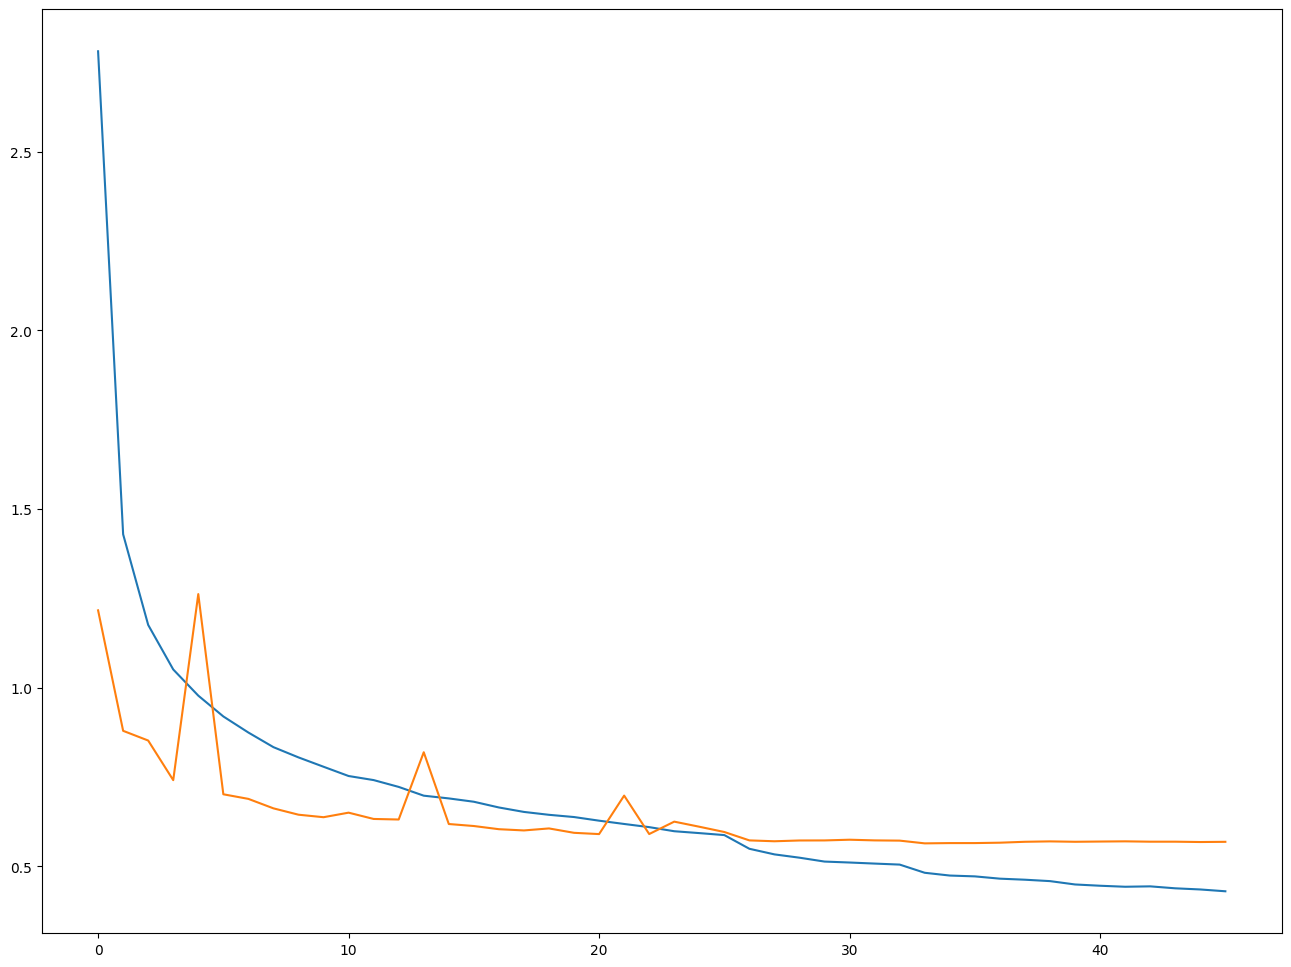

In [9]:
train_dataset = image_dataset_from_directory(
    '../data/train_small/',
    batch_size=32,
    color_mode='grayscale',
    image_size=(64,64),
    label_mode='categorical'
)

validation_dataset = image_dataset_from_directory(
    '../data/val_small/',
    batch_size=32,
    color_mode='grayscale',
    image_size=(64,64),
    label_mode='categorical'
)

alphabet_labels = train_dataset.class_names

model = create_cnn(output_size=(len(alphabet_labels)))
model = train_cnn(model, train_dataset, validation_dataset, epochs=100)

## Čuvanje i učitavanje modela NM

In [10]:
# Ovde ce biti omoguceno cuvanje modela
model.save('ocr_model')

INFO:tensorflow:Assets written to: ocr_model\assets


INFO:tensorflow:Assets written to: ocr_model\assets


In [11]:
# Ovde je moguce ucitati model
model_path = './ocr_model' # This is the directory created by model.save()

try:
    # Load the model
    model = tf.keras.models.load_model(model_path)
    print(f"Model successfully loaded from: {model_path}")

    # You can now use 'loaded_model' for predictions
    # Example: If you have new data 'new_data_for_prediction'
    # predictions = loaded_model.predict(new_data_for_prediction)

    # To see a summary of the loaded model (optional)
    model.summary()

except Exception as e:
    print(f"Error loading model: {e}")
    print(f"Please ensure '{model_path}' exists and contains a valid Keras SavedModel.")


Model successfully loaded from: ./ocr_model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 62, 62, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 60, 60, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 32)        0         
 D)                                                              
            

## Matrica konfuzije

In [ ]:
dir = "../data/val_small/"

real_results = []
predicted_results = []

for dir2 in os.listdir(dir):
    dirr = os.path.join(dir, dir2)
    for image_path in os.listdir(dirr):
        img = image_bin(image_gray(load_image(os.path.join(dirr,image_path))))
        prediction = model.predict(np.expand_dims(img, axis=0))

        predicted_results.append(winner(prediction[0]))
        real_results.append(dir2)

print("Real results:", real_results)
print("Predicted results:", predicted_results)

1/1 [==============================] - 0s 160ms/step
Real results: ['000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '

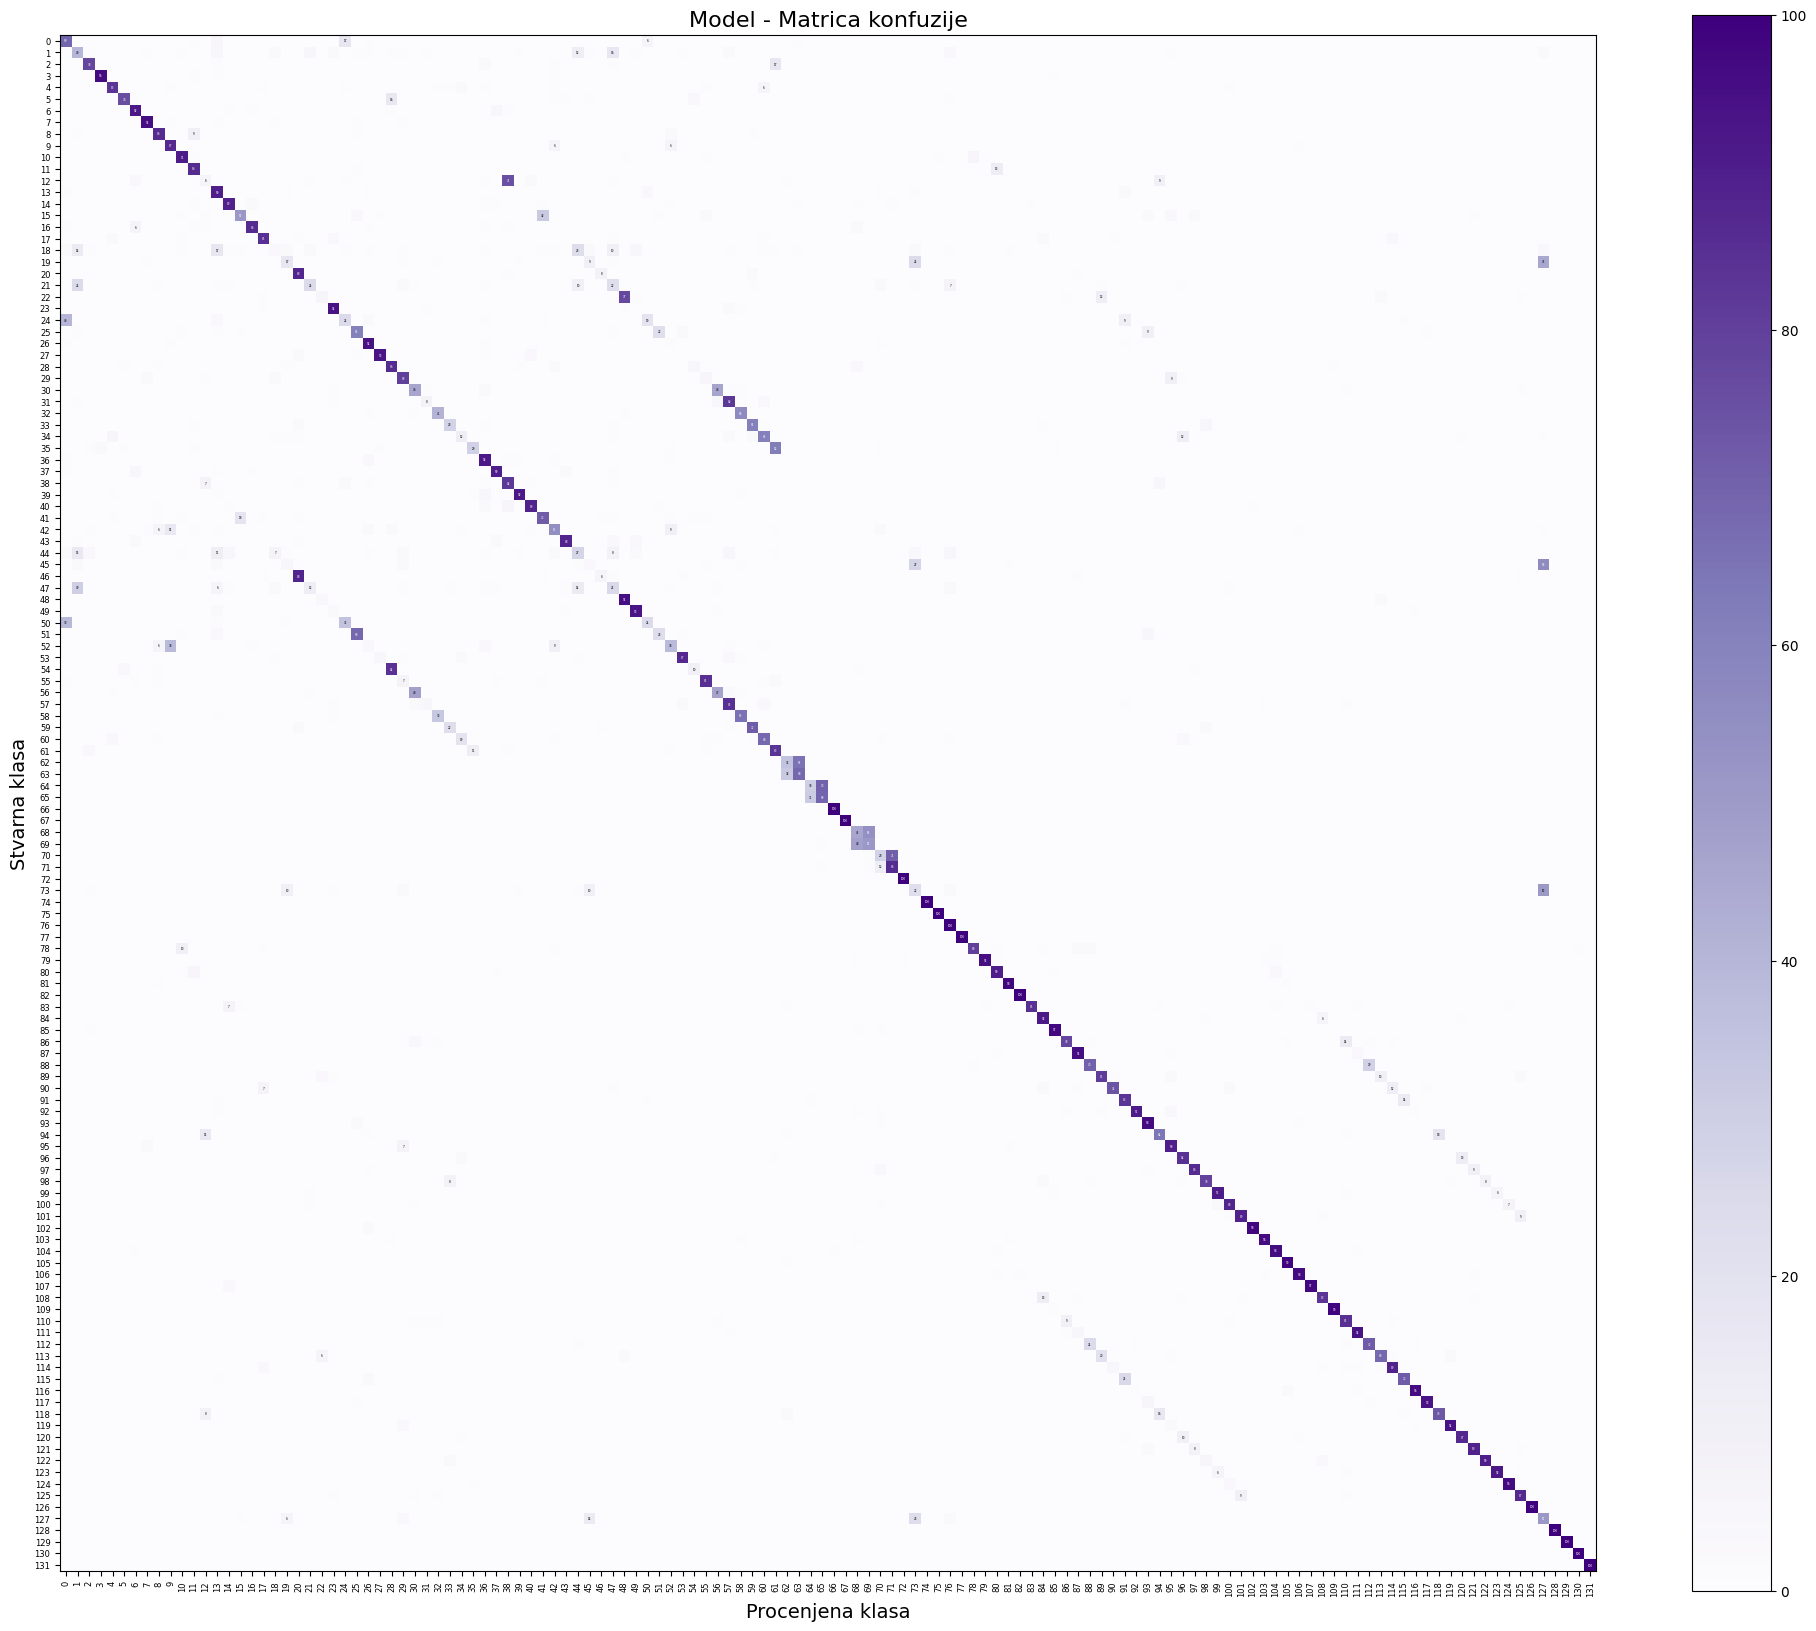

In [98]:
def matplotlib_confusion_matrix(real_labels, predicted_results, save_path=None):
    cm = confusion_matrix(real_labels, predicted_results)
    n_classes = cm.shape[0]
    
    # Adaptive sizing
    fig_size = min(20, max(8, n_classes * 0.3))
    font_size = max(2, 100 // n_classes)
    
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    
    # Create the heatmap using matplotlib's imshow
    im = ax.imshow(cm, interpolation='nearest', cmap='Purples')
    
    # Add colorbar
    plt.colorbar(im, shrink=0.8)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(n_classes):
        for j in range(n_classes):
            # Only show text if matrix is not too large or value is significant
            if n_classes <= 50 or cm[i, j] > cm.max() * 0.05:
                color = "white" if cm[i, j] > thresh else "black"
                ax.text(j, i, str(cm[i, j]), ha="center", va="center", 
                       color=color, fontsize=font_size)
    
    # Set labels and ticks
    ax.set_xlabel("Procenjena klasa", fontsize=14)
    ax.set_ylabel("Stvarna klasa", fontsize=14)
    ax.set_title("Model - Matrica konfuzije", fontsize=16)
    
    # Set tick marks
    tick_marks = np.arange(n_classes)
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    
    # Rotate labels if needed
    if n_classes > 15:
        plt.setp(ax.get_xticklabels(), rotation=90)
    elif n_classes > 8:
        plt.setp(ax.get_xticklabels(), rotation=45)
    
    # Adjust font size for tick labels
    ax.tick_params(axis='both', which='major', labelsize=max(6, font_size))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    return cm

alphabet_labels = os.listdir("../data/val_small/")
real_labels = [decimal_to_alphabet(x, alphabet, alphabet_labels) for x in real_results]
cm = matplotlib_confusion_matrix(real_labels, predicted_results, 'confusion_matrix.png')

## Testiranje NM

In [ ]:
# Postupak rada nad testnom slikom: 
# 1. Ucita se slika   -
# 2. Primeni se unskewed metoda -
# 3. Primeni se metoda za rotiranje -
# 4. Slika se binarizuje -
# 5. Slika se posalje na ekstrakciju podataka -
# 6. Dobijeni rezultat se preradi na osnovu alfabeta 
# 7. Prikaze se konacni rezultat

# Nacin exportovanja modela iz notebook-a je dostupan kod gemini-ja - Nenad
# 1. Ucitavanje
#test_image_path = '../data/emnist-train-latin-data/001/char_112.jpeg'
#print(f"Učitavam sliku: {test_image_path}")
#original_image = load_image(test_image_path)

# 2. i 3. tacku preskacemo

# 4. Binarizacija
#print("\nKorak: Binarizovanje slike ( image_bin)")
##original_image_bin = image_bin(image_gray(original_image))

# 5. Ekstrakcija teksta
#print("\nKorak: Prepoznavanje teksta (extract_text)")
#recognized_full_text = extract_text(original_image.copy(), ann, alphabet_labels)
#print(recognized_full_text)
# Get a sample from your training dataset
# Get a sample from your training dataset

# Get a sample from your training dataset
for images, labels in train_dataset.take(1):
    sample_image = images[0]  # Take the first image
    sample_label = labels[0]  # Take the first label
    break

# Convert back to the format your prediction function expects
sample_image_np = sample_image.numpy()
print(sample_image_np.dtype)
print(f"Original image shape: {sample_image_np.shape}")
print(f"Original image range: [{np.min(sample_image_np)}, {np.max(sample_image_np)}]")
print(f"True label: {alphabet_labels[np.argmax(sample_label)]}")

# Now predict on this image
prediction = model.predict(np.expand_dims(sample_image_np, axis=0))
predicted_letter = alphabet_labels[winner(prediction[0])]
print(f"Predicted letter: {predicted_letter}")

print("\n\n===================== random slika =====================")
test_image_path = '../data/train_processed/000/comnist_5a0d5cfd92c94.png'

print(f"Učitavam sliku: {test_image_path}")
original_image = load_image(test_image_path)
original_image_bin = image_bin(image_gray(original_image))
display_image(original_image_bin, color=False)

original_image_bin = prepare_for_cnn_one_region(original_image_bin)
print(f"Original image shape: {original_image_bin.shape}")
print(f"Original image range: [{np.min(original_image_bin)}, {np.max(original_image_bin)}]")
print(original_image_bin.dtype)
display_image(original_image_bin, color=False)

prediction = model.predict(np.expand_dims(original_image_bin, axis=0))
predicted_letter = alphabet_labels[winner(prediction[0])]
print(f"Predicted letter: {predicted_letter}")

In [ ]:
# Marija
# demonstracija rada algoritma

#hocu da napravim funkciju pa cu je pozivati i u ovoj celiji ali i u celiji ispod

def process_image(image_path, ann, alphabet, display_steps=True):     #dodala sam display_steps cisto da mogu da biram jel zelim sve ispisano ili ne
    """
    Procesira sliku: učitavanje, ispravljanje zakošenosti, rotacija, binarizacija i OCR.
    Vraća prepoznat tekst.
    """
    try:
        if display_steps:
            print(f"Učitavam sliku: {image_path}")
        original_image = load_image(image_path)

        if original_image is None:
            raise ValueError("Slika nije uspešno učitana. Proverite putanju i integritet fajla.")

        if display_steps:
            print(f"Slika '{image_path}' uspešno učitana. Dimenzije: {original_image.shape}")
            display_image(original_image, color=True)

            print("\nKorak 1: Ispravljanje zakošenosti")
        skew_corrected_image = correct_skewed_image(original_image.copy())
        if display_steps:
            display_image(skew_corrected_image, color=False)

            print("\nKorak 2: Rotiranje slike")
        rotated_image = rotate_image_to_normal(skew_corrected_image.copy(), image_gray(skew_corrected_image.copy()))
        if display_steps:
            display_image(rotated_image, color=True)

            print("\nKorak 3: Binarizacija slike")
        rotated_image_bin = image_bin(image_gray(rotated_image))
        if display_steps:
            display_image(rotated_image_bin, color=False)

        print("\nKorak 4: Prepoznavanje teksta")
        
        recognized_text = extract_text(rotated_image_bin.copy(), ann, alphabet)

        if display_steps:
            print("\nKorak 5: Konačni rezultat:")
            print(recognized_text)

        return recognized_text

    except FileNotFoundError:
        print(f"Greška: Slika na putanji '{image_path}' nije pronađena.")
    except NameError as ne:
        print(f"Greška: Nedostaje definicija '{ne}'")
    except ValueError as ve:
        print(f"Greška tokom obrade slike: {ve}")
    
    return None  # Ako nešto krene po zlu

result = process_image('../data/test/b01-057.png/b01-057.png', model, alphabet)

""""
test_image_path = '../data/test/b01-057.png/b01-057.png'

try:
    print(f"Učitavam sliku: {test_image_path}")
    original_image = load_image(test_image_path)

    
    if original_image is None:
        print(f"GREŠKA: Nije moguće učitati sliku sa putanje: {test_image_path}")
        print("Molimo proverite da li putanja postoji i da li je slika validna (nije oštećena/prazna).")
        # Prekida izvršavanje ako slika nije učitana kako bi se sprečila dalja greška.
       
        raise ValueError("Slika nije uspešno učitana. Proverite putanju i integritet fajla.")
    else:
        print(f"Slika '{test_image_path}' uspešno učitana. Dimenzije: {original_image.shape}")
    
        print("Prikaz originalne slike:")
        display_image(original_image, color=True)

        print("\nKorak 1: Ispravljanje zakošenosti (correct_skewed_image)")
        skew_corrected_image = correct_skewed_image(original_image.copy())
        print("Prikaz slike nakon ispravljanja zakošenosti:")
        display_image(skew_corrected_image, color=False)

        print("\nKorak 2: Rotiranje slike do normalne orijentacije (rotate_image_to_normal)")
        rotated_image = rotate_image_to_normal(skew_corrected_image.copy(), image_gray(skew_corrected_image.copy()))
        print("Prikaz slike nakon rotacije:")
        display_image(rotated_image, color=True)

        print("\nKorak 3: Binarizovanje slike ( image_bin)")
        rotated_image_bin = image_bin(image_gray(rotated_image))
        print("Prikaz slike nakon binarizacije:")
        display_image(rotated_image_bin, color=False)                   #jel treba color

        print("\nKorak 4: Prepoznavanje teksta (extract_text)")
        recognized_full_text = extract_text(rotated_image_bin.copy(), ann, alphabet)

        # Dobijeni rezultat se preradi na osnovu alfabeta -> mislim da ovo radi prethodni korak
        # ali me ispravi ako gresim

        print("\nKorak 5: Prikaz konačnog rezultata")
        print(recognized_full_text)


except FileNotFoundError:
    print(f"Greška: Slika na putanji '{test_image_path}' nije pronađena. Molimo proverite putanju i ime fajla.")
except NameError as ne:
    print(f"Greška: Nedostaje definicija '{ne}'. Proverite da li su 'ann', 'alphabet' i sve ostale potrebne funkcije definisane u gornjim ćelijama i izvršene.")
except ValueError as ve:
    print(f"Greška tokom obrade slike: {ve}")
# Uklonjen je opšti 'except Exception as e' blok koji je ispisivao generičku poruku,
# sada će se greške specifičnije uhvatiti ili će se prikazati kompletan traceback
# za druge neočekivane greške.

"""


In [ ]:
#Marija
#Pokrecem OCR nad svim ostalim testnim primerima i 
#prikazujem uspesnost upotrebom metrika za stringove

#1. priprema podataka

#1.1kreiram listu test slika i resenja
from pathlib import Path


image_paths = ['../data/test/a01-003x.png/a01-003x.png', '../data/test/a01-007x.png/a01-007x.png', '../data/test/a01-011x.png/a01-011x.png', '../data/test/a01-014x.png/a01-014x.png', '../data/test/a01-020.png/a01-020.png', '../data/test/a01-026.png/a01-026.png', '../data/test/a01-030.png/a01-030.png', '../data/test/a01-030x.png/a01-030x.png', '../data/test/a01-117.png/a01-117.png', '../data/test/a02-000.png/a02-000.png', '../data/test/a02-008.png/a02-008.png', '../data/test/b01-057.png/b01-057.png', '../data/test/b02/b02.png' ]

text_paths = ['../data/test/a01-003x.png/a01-003x.txt', '../data/test/a01-007x.png/a01-007x.txt', '../data/test/a01-011x.png/a01-011x.txt', '../data/test/a01-014x.png/a01-014x.txt', '../data/test/a01-020.png/a01-020.txt', '../data/test/a01-026.png/a01-026.txt', '../data/test/a01-030.png/a01-030.txt', '../data/test/a01-030x.png/a01-030x.txt', '../data/test/a01-117.png/a01-117.txt', '../data/test/a02-000.png/a02-000.txt', '../data/test/a02-008.png/a02-008.txt', '../data/test/b01-057.png/b01-057.txt', '../data/test/b02/b02.txt' ]

test_data = []

#1.2 pravim parove (slika, ucitani tekst)
for img_path, txt_path in zip(image_paths, text_paths):
    gt_text = Path(txt_path).read_text(encoding='utf-8').strip()
    test_data.append((img_path, gt_text))


In [ ]:
#2. Pokreni OCR model nad svakim primerom
#2.1 Učitaj sliku.

results = []

for img_path, gt_text in test_data:
    print(f"Obrada slike: {img_path}")
    prediction = process_image(img_path, model, alphabet)
    if prediction is None:
        print("OCR nije uspeo.")
        continue

    results.append({
        'ime_slike' : img_path,
        'ground_truth': gt_text,
        'prediction': prediction
    })



In [ ]:
#Marija
#pokusaj da resim problem sa okruzenjem
#predlog dao chatgpt

import sys
print(sys.executable)

In [ ]:
import Levenshtein
print(Levenshtein.distance("test", "tekst"))

In [ ]:
#Marija

#3. Izračunaj metrike upoređivanjem sa ground truth tekstom
# ideja: za svaki element iz results izracunacu : 
    #Levenstajnovo rastojanje
    #Hamingovo rastojanje
    #Accuracy

for r in results:
    gt = r['ground_truth']
    pred = r['prediction']

    #ovo dodajem da se osiguram da su i gt i pred stringovi
    #jer je pre javljalo gresku
    gt = ''.join(r['ground_truth']) if isinstance(r['ground_truth'], list) else str(r['ground_truth'])
    pred = ''.join(r['prediction']) if isinstance(r['prediction'], list) else str(r['prediction'])

    r['levenshtein'] = Levenshtein.distance(pred, gt)

    if len(gt) == len(pred):
        r['hamming'] = sum(c1 != c2 for c1, c2 in zip(gt, pred))
    else:
        r['hamming'] = None

    # 3.1 Accuracy = broj tačnih karaktera / ukupno karaktera
    tacni = sum(c1 == c2 for c1, c2 in zip(gt, pred))
    r['accuracy'] = tacni / max(len(gt), len(pred), 1)  # štiti od deljenja sa nulom